# Load Dataset

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="CxmnmwblpBjFuOlo5vKY")
project = rf.workspace("bestgetsbetter").project("jpj")
version = project.version(1)
dataset = version.download("yolov12")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 110.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.


Extracting Dataset Version Zip to JPJ-1 in yolov12:: 100%|██████████| 2275/2275 [00:00<00:00, 8908.09it/s]


In [2]:
# ============================================================
# INSTALL & IMPORTS
# ============================================================

import os, glob, random, shutil, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import albumentations as A
from tqdm import tqdm

In [3]:
root = dataset.location
print("Dataset root folder:", root)

# Auto-detect all image folders
possible_subfolders = ["train", "valid", "test"]
image_paths = []

for subset in possible_subfolders:
    # Check direct folder: /train/*.jpg
    path1 = os.path.join(root, subset)
    # Check YOLO folder: /train/images/*.jpg
    path2 = os.path.join(root, subset, "images")

    if os.path.exists(path1):
        image_paths.extend(glob.glob(path1 + "/*.jpg"))
        image_paths.extend(glob.glob(path1 + "/*.png"))

    if os.path.exists(path2):
        image_paths.extend(glob.glob(path2 + "/*.jpg"))
        image_paths.extend(glob.glob(path2 + "/*.png"))

# Pick 3 sample images
sample_imgs = image_paths[:3]

print("Found images:", len(image_paths))
print("Selected 3 images:")
for p in sample_imgs:
    print(p)

Dataset root folder: /kaggle/working/JPJ-1
Found images: 1133
Selected 3 images:
/kaggle/working/JPJ-1/train/images/2023-06-15_14-11-53-front_mp4_360_jpg.rf.8bbef1c5672cfcaca87812598da2d4b1.jpg
/kaggle/working/JPJ-1/train/images/20230619181908_247525_TS_2880_jpg.rf.bdd902c65557821b18fd4093c9c2203e.jpg
/kaggle/working/JPJ-1/train/images/20230619163057_247468_TS_600_jpg.rf.b370885d352e3d997163769ceff6b089.jpg


# Define Intensity Transformation Functions

In [4]:
# ============================================================
# INTENSITY TRANSFORMATION FUNCTIONS
# ============================================================

def log_transformation(img):
    img = img.astype(np.float32)
    c = 255 / np.log(1 + np.max(img))
    log_img = c * (np.log(img + 1))
    return np.uint8(np.clip(log_img, 0, 255))

def gamma_correction(img, gamma=1.5):
    img_normalized = img / 255.0
    gamma_img = np.power(img_normalized, gamma)
    return np.uint8(gamma_img * 255)

def contrast_stretching(img):
    r_min, r_max = np.min(img), np.max(img)
    stretched = (img - r_min) * (255 / (r_max - r_min))
    return np.uint8(stretched)

def clahe_equalization(img):
    if len(img.shape) == 3: 
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        L, A, B = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        L_clahe = clahe.apply(L)

        final = cv2.merge((L_clahe, A, B))
        return cv2.cvtColor(final, cv2.COLOR_LAB2BGR)
    else:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(img)

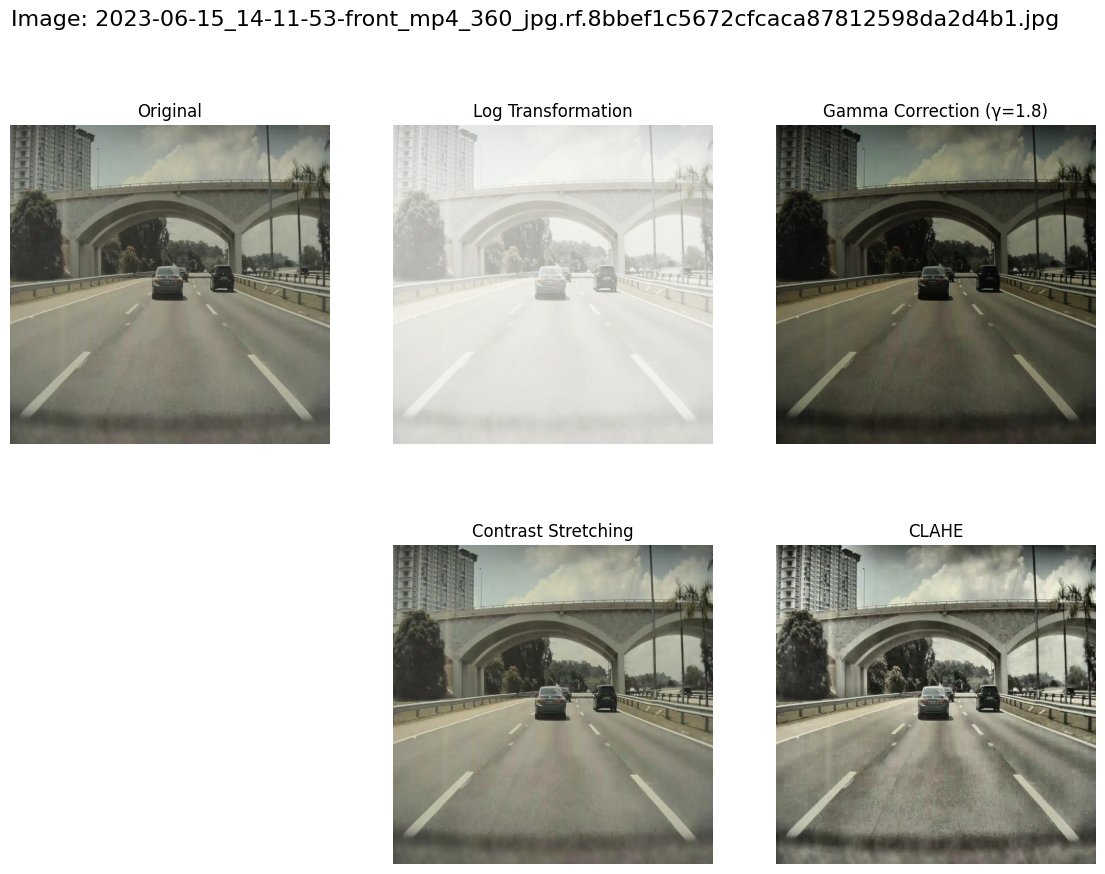

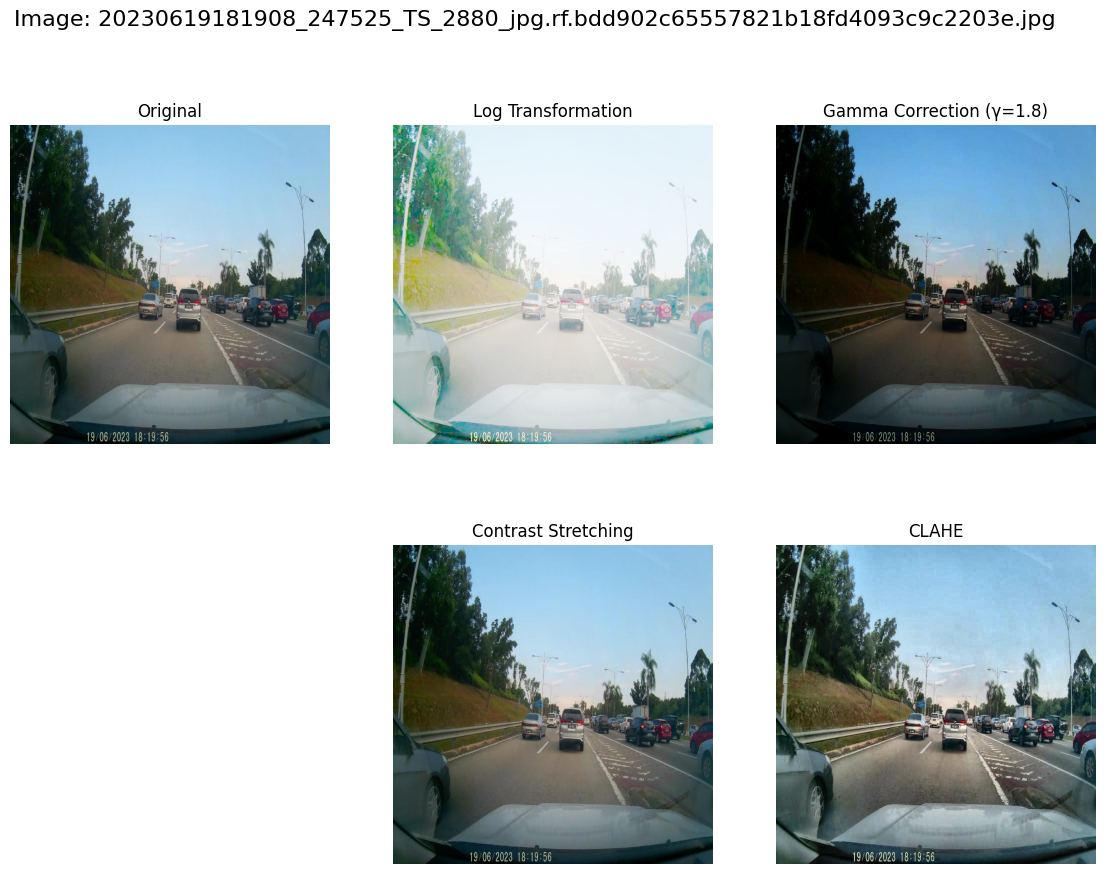

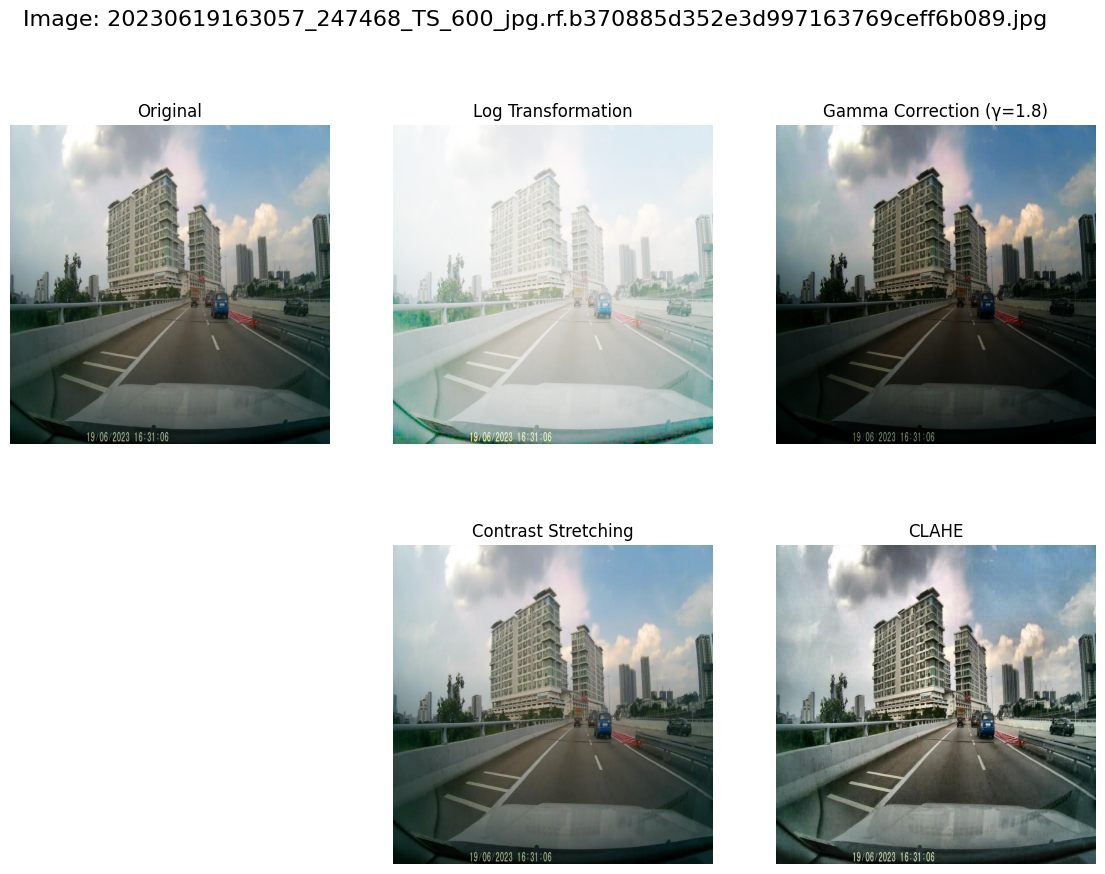

In [5]:
# ============================================================
# APPLY TRANSFORMATIONS & DISPLAY
# ============================================================

for img_path in sample_imgs:

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # for matplotlib

    # Apply transformations
    log_img = log_transformation(img)
    gamma_img = gamma_correction(img, gamma=1.8)
    stretch_img = contrast_stretching(img)
    clahe_img = clahe_equalization(img)

    # Plot outputs
    plt.figure(figsize=(14, 10))
    plt.suptitle(f"Image: {os.path.basename(img_path)}", fontsize=16)

    plt.subplot(2, 3, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(log_img)
    plt.title("Log Transformation")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(gamma_img)
    plt.title("Gamma Correction (γ=1.8)")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(stretch_img)
    plt.title("Contrast Stretching")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(clahe_img)
    plt.title("CLAHE")
    plt.axis("off")

    plt.show()

# Define Filtering Functions

In [6]:
# ============================================================
# FILTER FUNCTIONS
# ============================================================

def mean_filter(img, ksize=5):
    return cv2.blur(img, (ksize, ksize))

def gaussian_filter(img, ksize=5, sigma=1):
    return cv2.GaussianBlur(img, (ksize, ksize), sigma)

def median_filter(img, ksize=5):
    return cv2.medianBlur(img, ksize)

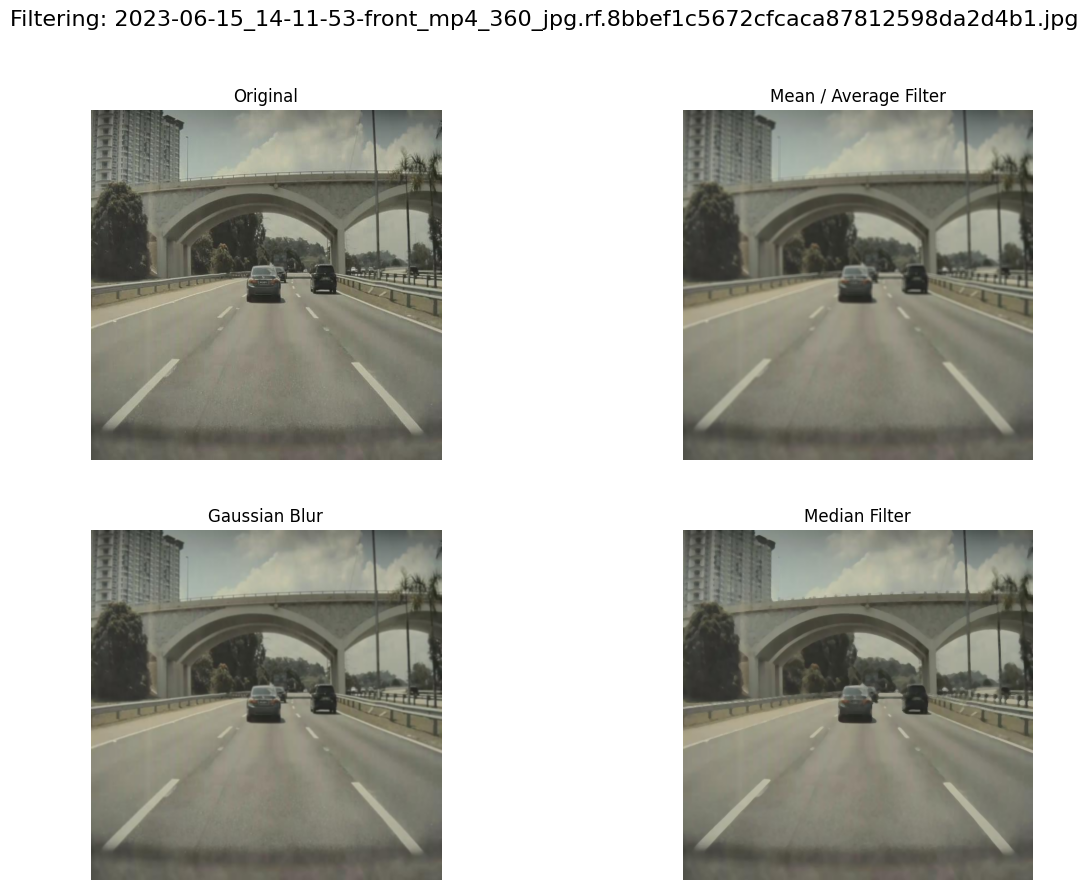

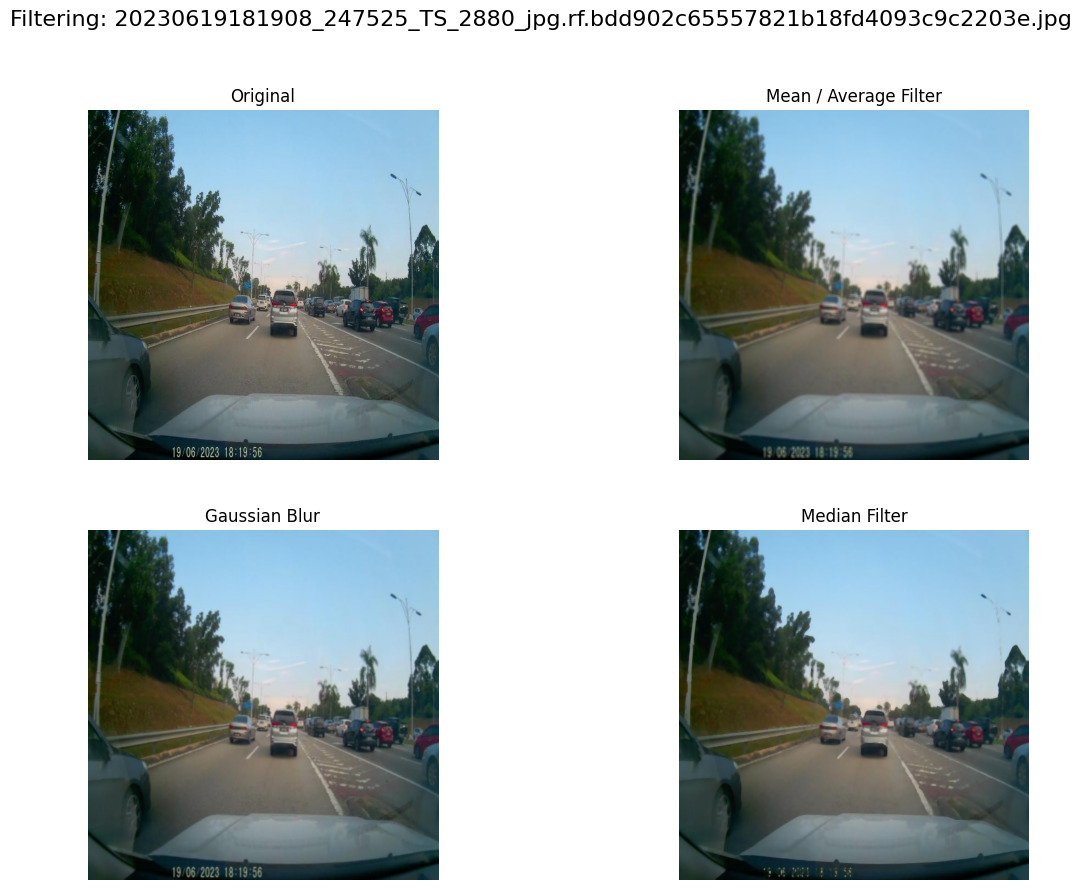

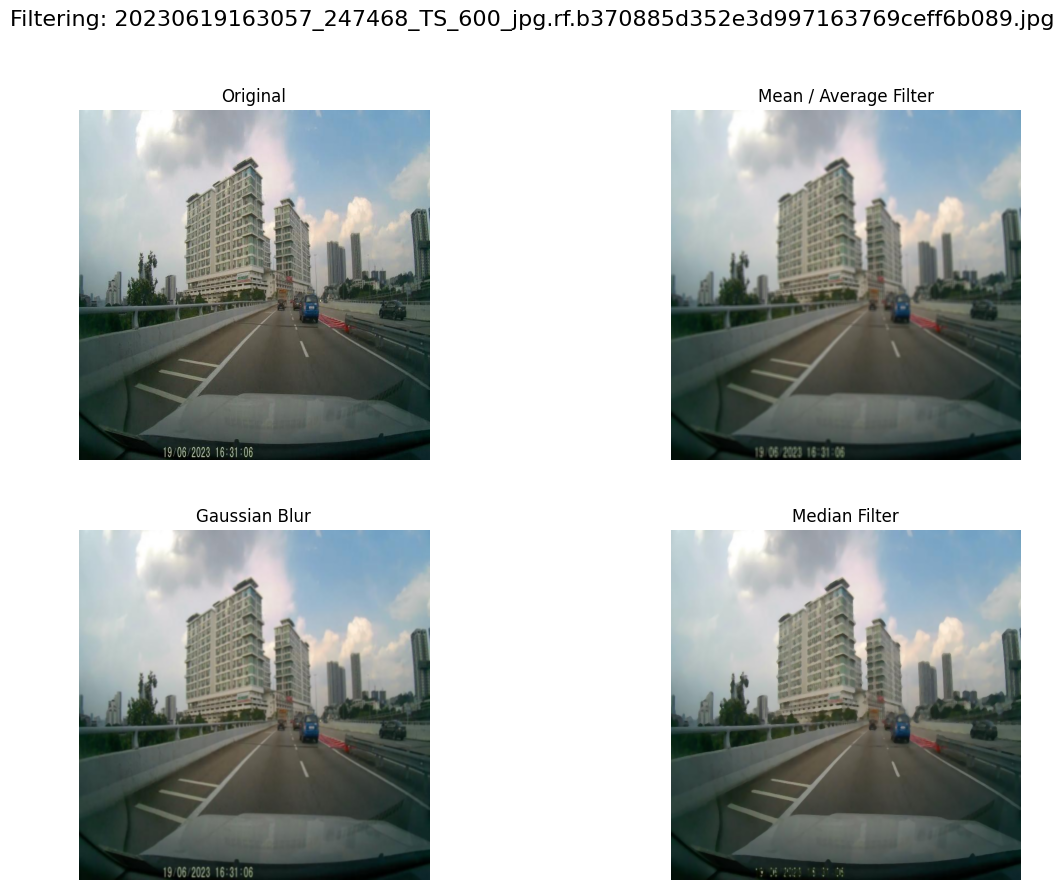

In [7]:
# ============================================================
# APPLY FILTERS & DISPLAY
# ============================================================

for img_path in sample_imgs:

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mean_img = mean_filter(img, ksize=5)
    gaussian_img = gaussian_filter(img, ksize=5, sigma=1)
    median_img = median_filter(img, ksize=5)

    plt.figure(figsize=(14, 10))
    plt.suptitle(f"Filtering: {os.path.basename(img_path)}", fontsize=16)

    plt.subplot(2, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(mean_img)
    plt.title("Mean / Average Filter")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(gaussian_img)
    plt.title("Gaussian Blur")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(median_img)
    plt.title("Median Filter")
    plt.axis("off")

    plt.show()

# Create the data.yaml file

In [8]:
%%writefile /kaggle/working/data.yaml
# ============================================================
# YOLOv12 Dataset Configuration for Instance Segmentation
# ============================================================

train: /kaggle/working/JPJ-1/train/images
val: /kaggle/working/JPJ-1/test/images
test: /kaggle/working/JPJ-1/test/images

# Number of classes
nc: 6

# Class names
names: ['divider-line','dotted-line','double-line','random-line','road-sign-line','solid-line']

Writing /kaggle/working/data.yaml


# Sample Visualization with Labels

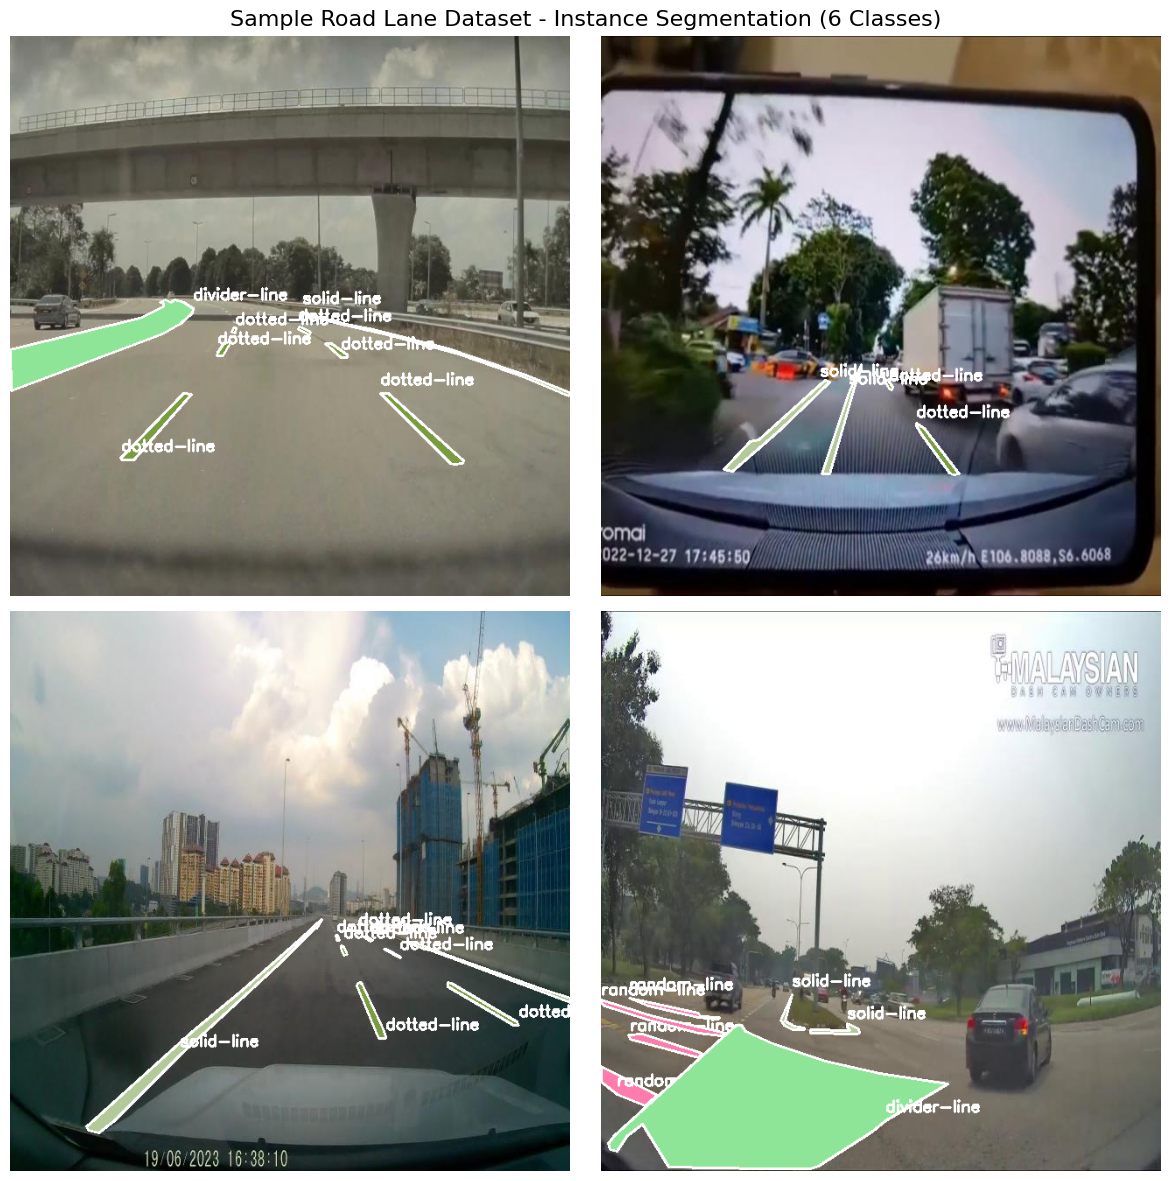

In [9]:
# ============================================================
# YOLOv11 Instance Segmentation Visualization (6 Classes)
# ============================================================

# Paths
image_dir = "/kaggle/working/JPJ-1/train/images"
label_dir = "/kaggle/working/JPJ-1/train/labels"

# Class names (must match YOLO class IDs)
CLASS_NAMES = [
    "divider-line",     # class 0
    "dotted-line",      # class 1
    "double-line",      # class 2
    "random-line",      # class 3
    "road-sign-line",   # class 4
    "solid-line"        # class 5
]

# Assign fixed colors to each class for consistent visualization
np.random.seed(42)  # for consistent colors across runs
CLASS_COLORS = {
    i: tuple(np.random.randint(50, 255, 3).tolist()) for i in range(len(CLASS_NAMES))
}

# Get random sample of 4 images
image_files = random.sample(os.listdir(image_dir), 4)

def visualize_image(img_path, label_path):
    """Visualize one image with segmentation masks or bboxes for all classes."""
    img = cv2.imread(img_path)
    if img is None:
        return np.zeros((100, 100, 3), dtype=np.uint8)

    h, w = img.shape[:2]
    overlay = img.copy()

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            values = list(map(float, line.strip().split()))
            cls_id = int(values[0])
            coords = values[1:]
            class_name = CLASS_NAMES[cls_id] if cls_id < len(CLASS_NAMES) else f"class_{cls_id}"
            color = CLASS_COLORS.get(cls_id, (255, 255, 255))

            # Polygon segmentation (YOLOv12 mask format)
            if len(coords) > 4:
                pts = np.array(coords).reshape(-1, 2)
                pts[:, 0] *= w
                pts[:, 1] *= h
                pts = pts.astype(np.int32)
                cv2.fillPoly(overlay, [pts], color)
                cv2.polylines(overlay, [pts], True, (255, 255, 255), 2)
                cv2.putText(overlay, class_name, (pts[0][0], max(pts[0][1] - 10, 20)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            else:
                # Bounding box fallback
                xc, yc, bw, bh = coords
                x1, y1 = int((xc - bw / 2) * w), int((yc - bh / 2) * h)
                x2, y2 = int((xc + bw / 2) * w), int((yc + bh / 2) * h)
                cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 2)
                cv2.putText(overlay, class_name, (x1, max(y1 - 5, 20)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return overlay

# ============================================================
# Show 4 Random Images (2x2 Grid)
# ============================================================
plt.figure(figsize=(12, 12))
for idx, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.rsplit('.', 1)[0] + ".txt")
    vis = visualize_image(img_path, label_path)

    plt.subplot(2, 2, idx + 1)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.suptitle("Sample Road Lane Dataset - Instance Segmentation (6 Classes)", fontsize=16)
plt.tight_layout()
plt.show()

# Setup

In [10]:
!pip -q install --upgrade ultralytics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.5 MB/s eta 0:00:00


In [11]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Point to data.yaml & quick sanity checks

In [12]:
DATA_YAML = "/kaggle/working/data.yaml"

# Show the YAML file for quick confirmation
print(open(DATA_YAML).read())

# Optional: basic file count checks (train/val/test)
import yaml
cfg = yaml.safe_load(open(DATA_YAML))
for split in ["train", "val", "test"]:
    if split in cfg and cfg[split]:
        img_dir = cfg[split]
        n = len(glob.glob(os.path.join(img_dir, "*.*")))
        print(f"{split:<5} -> {img_dir} : {n} files")

# ============================================================
# YOLOv12 Dataset Configuration for Instance Segmentation
# ============================================================

train: /kaggle/working/JPJ-1/train/images
val: /kaggle/working/JPJ-1/test/images
test: /kaggle/working/JPJ-1/test/images

# Number of classes
nc: 6

# Class names
names: ['divider-line','dotted-line','double-line','random-line','road-sign-line','solid-line']

train -> /kaggle/working/JPJ-1/train/images : 1021 files
val   -> /kaggle/working/JPJ-1/test/images : 112 files
test  -> /kaggle/working/JPJ-1/test/images : 112 files


# Train YOLOv11 (segmentation)

In [13]:
# Load a model
model = YOLO("yolo11n-seg.yaml").load("yolo11n.pt")  # build from YAML and transfer weights

results = model.train(
    data=DATA_YAML,
    epochs=50,            # adjust as needed
    imgsz=640,
    batch=8,              # tune based on GPU memory
    workers=2,
    device=0,             # 0 for GPU, 'cpu' for CPU
    patience=10,          # early stopping
    save=True,
    save_period=-1,       # set >0 to save every N epochs
    pretrained=True,
    optimizer="auto",
    project="/kaggle/working/yolo11_runs",
    name="road_yolo11_seg",
    exist_ok=True,
    amp=True              # mixed precision (faster on modern GPUs)
)

print("Training finished. Best weights should be in 'best.pt' under the run directory.")

Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=road_yolo11_seg, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_ma

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.711      0.683      0.745      0.546      0.726      0.619      0.698      0.401
          divider-line         21         26      0.705      0.808       0.78      0.597      0.656      0.733      0.682      0.477
           dotted-line         96        621      0.926      0.728      0.866      0.622      0.832      0.617       0.75      0.396
           double-line          3          4      0.373       0.75      0.697      0.577      0.435       0.75      0.679      0.408
           random-line         19        104      0.685      0.529      0.604      0.334      0.791      0.481      0.618       0.28
        road-sign-line         14         24      0.713      0.517      0.644      0.422      0.761      0.417      0.594      0.338
            solid-line        105        203      0.862      0.768      0.881      0.726      0.884      0.716      0.863      0.507
Speed: 0.6ms preprocess, 5.2ms inference, 0.0ms loss, 6.7ms postproce

# Validation (mAP, precision/recall, confusion matrix)

In [14]:
# Locate best weights from the run folder
run_dir = results.save_dir if hasattr(results, "save_dir") else "/kaggle/working/yolo11_runs/road_yolo11_seg"
best_ckpt = os.path.join(run_dir, "weights", "best.pt")
print("Using weights:", best_ckpt)

model = YOLO(best_ckpt)
val_metrics = model.val(split="val")   # uses val set in data.yaml

# The .val() call prints a summary and saves plots (PR curves, confusion, F1, etc.)
# You can also access metrics programmatically:
try:
    # For segmentation: metrics.box.map and metrics.seg.map exist on recent ultralytics
    print("Box  mAP50-95:", getattr(val_metrics.box, "map", None))
    print("Mask mAP50-95:", getattr(val_metrics.seg, "map", None))
except:
    pass

Using weights: /kaggle/working/yolo11_runs/road_yolo11_seg/weights/best.pt
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,835,738 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1182.0±538.8 MB/s, size: 40.9 KB)
val: Scanning /kaggle/working/JPJ-1/test/labels.cache... 112 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 112/112 257.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.5it/s 4.7s


invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.713      0.684      0.747      0.548      0.725      0.615      0.685      0.392
          divider-line         21         26      0.706      0.808       0.78      0.603      0.656      0.732      0.682      0.472
           dotted-line         96        621      0.928      0.729      0.872      0.628      0.819      0.605      0.733      0.376
           double-line          3          4      0.374       0.75      0.697      0.577      0.435       0.75      0.679      0.408
           random-line         19        104      0.693      0.529      0.607      0.331      0.787      0.471      0.601      0.274
        road-sign-line         14         24      0.713      0.518      0.645      0.422      0.769      0.417      0.557      0.316
            solid-line        105        203      0.862      0.768      0.881      0.728      0.884      0.716       0.86      0.502
Speed: 3.8ms preprocess, 8.3ms inference, 0.0ms loss, 6.6ms postproce

# Test set evaluation

In [15]:
# Evaluate on test split if defined in data.yaml
try:
    test_metrics = model.val(split="test")
    try:
        print("Test Box  mAP50-95:", getattr(test_metrics.box, "map", None))
        print("Test Mask mAP50-95:", getattr(test_metrics.seg, "map", None))
    except:
        pass
except Exception as e:
    print("Test evaluation skipped or failed:", e)

Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1331.7±338.7 MB/s, size: 41.7 KB)
val: Scanning /kaggle/working/JPJ-1/test/labels.cache... 112 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 112/112 271.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.4it/s 5.0s


invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.713      0.684      0.747      0.548      0.725      0.615      0.685      0.392
          divider-line         21         26      0.706      0.808       0.78      0.603      0.656      0.732      0.682      0.472
           dotted-line         96        621      0.928      0.729      0.872      0.628      0.819      0.605      0.733      0.376
           double-line          3          4      0.374       0.75      0.697      0.577      0.435       0.75      0.679      0.408
           random-line         19        104      0.693      0.529      0.607      0.331      0.787      0.471      0.601      0.274
        road-sign-line         14         24      0.713      0.518      0.645      0.422      0.769      0.417      0.557      0.316
            solid-line        105        203      0.862      0.768      0.881      0.728      0.884      0.716       0.86      0.502
Speed: 3.6ms preprocess, 7.1ms inference, 0.0ms loss, 6.7ms postproce

# Predict & visualize a few samples from the test set


0: 640x640 8 dotted-lines, 2 random-lines, 2 solid-lines, 15.8ms
1: 640x640 6 dotted-lines, 2 solid-lines, 15.8ms
2: 640x640 6 dotted-lines, 1 solid-line, 15.8ms
3: 640x640 11 dotted-lines, 2 road-sign-lines, 3 solid-lines, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 dotted-lines, 2 random-lines, 2 solid-lines, 7.3ms
1: 640x640 6 dotted-lines, 2 solid-lines, 7.3ms
2: 640x640 6 dotted-lines, 1 solid-line, 7.3ms
3: 640x640 11 dotted-lines, 2 road-sign-lines, 3 solid-lines, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


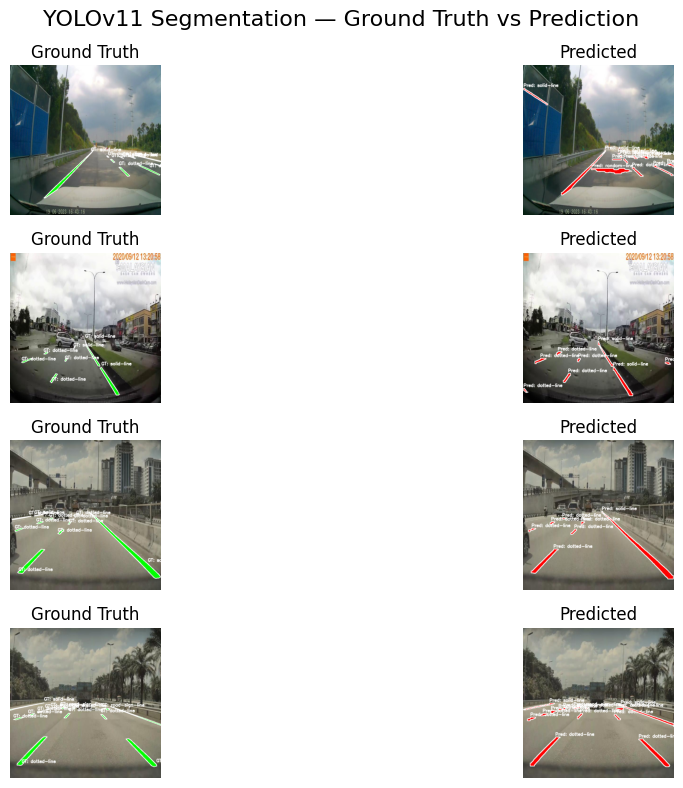

In [16]:
# ============================================================
# YOLOv11 Segmentation — Predicted vs Ground Truth Comparison
# ============================================================

import os, glob, random, cv2
import numpy as np
import matplotlib.pyplot as plt

# Pick a few random test images
test_dir = cfg.get("test")
label_dir = test_dir.replace("/images", "/labels")  # assumes standard YOLO structure

sample_imgs = []
if test_dir and os.path.isdir(test_dir):
    all_imgs = [p for p in glob.glob(os.path.join(test_dir, "*.*"))
                if p.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))]
    sample_imgs = random.sample(all_imgs, min(4, len(all_imgs)))

# ------------------------------------------------------------
# Helper to draw polygons from YOLO label file (Ground Truth)
# ------------------------------------------------------------
def draw_gt_polygons(img_path, label_path, class_names=["divider-line",     # class 0
    "dotted-line",      # class 1
    "double-line",      # class 2
    "random-line",      # class 3
    "road-sign-line",   # class 4
    "solid-line"]):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    overlay = img.copy()

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                vals = list(map(float, line.strip().split()))
                cls_id = int(vals[0])
                coords = vals[1:]
                if len(coords) > 4:
                    pts = np.array(coords).reshape(-1, 2)
                    pts[:, 0] *= w
                    pts[:, 1] *= h
                    pts = pts.astype(np.int32)
                    color = (0, 255, 0)  # green for GT
                    cv2.fillPoly(overlay, [pts], color)
                    cv2.polylines(overlay, [pts], True, (255, 255, 255), 2)
                    label = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
                    cv2.putText(overlay, f"GT: {label}", (pts[0][0], pts[0][1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    else:
        print(f"No label file found for {os.path.basename(img_path)}")

    return overlay

# ------------------------------------------------------------
# Helper to draw predicted polygons
# ------------------------------------------------------------
def draw_pred_polygons(result):
    img = result.orig_img.copy()

    if getattr(result, "masks", None) is not None and result.masks is not None:
        for i, seg in enumerate(result.masks.xy):
            poly = np.array(seg, dtype=np.int32)
            color = (0, 0, 255)  # red for predictions
            cv2.fillPoly(img, [poly], color)
            cv2.polylines(img, [poly], True, (255, 255, 255), 2)
            if getattr(result, "names", None) is not None and getattr(result.boxes, "cls", None) is not None:
                cls_id = int(result.boxes.cls[i].item())
                label = result.names.get(cls_id, str(cls_id)) if isinstance(result.names, dict) else str(cls_id)
                x, y = poly[0]
                cv2.putText(img, f"Pred: {label}", (int(x), int(y) - 6),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    else:
        print("⚠️ No predicted masks found for:", result.path)

    return img

# ------------------------------------------------------------
# Run inference on test set
# ------------------------------------------------------------
preds = model.predict(source=sample_imgs, imgsz=640, conf=0.25, device=0, save=False)

# ------------------------------------------------------------
# Run inference on test set
# ------------------------------------------------------------
preds = model.predict(source=sample_imgs, imgsz=640, conf=0.25, device=0, save=False)

# ------------------------------------------------------------
# Plot Predicted vs Ground Truth
# ------------------------------------------------------------
plt.figure(figsize=(14, 8))
for i, result in enumerate(preds):
    img_path = result.path
    label_path = os.path.join(label_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
    
    # Prepare visualizations
    vis_pred = draw_pred_polygons(result)
    vis_gt = draw_gt_polygons(img_path, label_path)

    vis_pred_rgb = cv2.cvtColor(vis_pred, cv2.COLOR_BGR2RGB)
    vis_gt_rgb = cv2.cvtColor(vis_gt, cv2.COLOR_BGR2RGB)

    # Show side by side
    plt.subplot(len(preds), 2, 2*i + 1)
    plt.imshow(vis_gt_rgb)
    #plt.title(f"GT: {os.path.basename(img_path)}")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(len(preds), 2, 2*i + 2)
    plt.imshow(vis_pred_rgb)
    plt.title("Predicted")
    plt.axis("off")

plt.suptitle("YOLOv11 Segmentation — Ground Truth vs Prediction", fontsize=16)
plt.tight_layout()
plt.show()

In [17]:
# === Paths for Pseudo-Labeling Setup ===
DATA_YAML = "/kaggle/working/data.yaml"
BASE_PATH = "/kaggle/working/JPJ-1"

# Labeled and Unlabeled folders (for Pseudo-Labeling)
LABELED_PATH = "/kaggle/working/pseudolabel_labeled"
UNLABELED_PATH = "/kaggle/working/pseudolabel_unlabeled"

# Create necessary folders
os.makedirs(f"{LABELED_PATH}/images", exist_ok=True)
os.makedirs(f"{LABELED_PATH}/labels", exist_ok=True)
os.makedirs(f"{UNLABELED_PATH}/images", exist_ok=True)
os.makedirs(f"{UNLABELED_PATH}/labels", exist_ok=True)

# Load and shuffle images
all_imgs = glob.glob(os.path.join(BASE_PATH, "train/images", "*.*"))
random.shuffle(all_imgs)

# 20% labeled, 80% unlabeled split
split_idx = int(len(all_imgs) * 0.2)
labeled_imgs = all_imgs[:split_idx]
unlabeled_imgs = all_imgs[split_idx:]

# Copy function for image-label pairs
def copy_data(img_list, dst_dir):
    for img in img_list:
        base = os.path.splitext(os.path.basename(img))[0]
        lbl = img.replace("images", "labels").rsplit(".", 1)[0] + ".txt"

        # Copy image
        shutil.copy(img, os.path.join(dst_dir, "images", os.path.basename(img)))

        # Copy label only if it exists (unlabeled data might not have it)
        if os.path.exists(lbl):
            shutil.copy(lbl, os.path.join(dst_dir, "labels", base + ".txt"))

copy_data(labeled_imgs, LABELED_PATH)
copy_data(unlabeled_imgs, UNLABELED_PATH)

print(f"✅ Pseudo-Label split done → {len(labeled_imgs)} labeled | {len(unlabeled_imgs)} unlabeled")

✅ Pseudo-Label split done → 204 labeled | 817 unlabeled


In [18]:
# ============================================================
# STEP 2️⃣ : Augmentations for Pseudo-Labeling
# ============================================================

# Weak augmentations for both labeled + unlabeled images
weak_aug = A.Compose([
    A.Resize(640, 640),
    A.HorizontalFlip(p=0.5),
])

print("✅ Pseudo-Labeling augmentations ready")

✅ Pseudo-Labeling augmentations ready


In [19]:
import torch

# ============================================================
# STEP 3️⃣ : Config (Pseudo-Labeling)
# ============================================================

device = "cuda" if torch.cuda.is_available() else "cpu"

# Pseudo-Labeling parameters
PSEUDO_CONF_THRESH = 0.9     # higher confidence threshold for stable pseudo labels
PSEUDO_UPDATE_FREQ = 1       # how often to regenerate pseudo labels (in epochs)

EPOCHS = 10

PSEUDO_YAML = "/kaggle/working/pseudolabel_labeled.yaml"

# Create YAML file for LABELED subset (used in supervised training part)
with open(PSEUDO_YAML, "w") as f:
    f.write(f"""
train: {LABELED_PATH}/images
val: {BASE_PATH}/test/images
nc: 6
names: ['divider-line','dotted-line','double-line','random-line','road-sign-line','solid-line']
""")

print("✅ Pseudo-Labeling config ready")

✅ Pseudo-Labeling config ready


In [20]:
# PASTE THIS CELL: Segmentation pseudo-label generator (safe)

def generate_seg_pseudo_labels(model, unlabeled_img_paths, unlabeled_labels_dir,
                               conf_thresh=0.7, min_area_px=100, save_limit=None):
    """
    model: loaded YOLO seg model
    unlabeled_img_paths: list of image file paths
    unlabeled_labels_dir: where to write pseudo label txts (one per image)
    conf_thresh: minimum box/confidence to accept mask
    min_area_px: minimum mask area (in pixels) to accept (avoid tiny junk)
    save_limit: optional limit on number of images to pseudo-label (for debug)
    Returns: list of image paths that received >=1 pseudo label
    """
    os.makedirs(unlabeled_labels_dir, exist_ok=True)
    selected_images = []
    count = 0

    for img_path in tqdm(unlabeled_img_paths, desc="Generating pseudo labels"):
        if save_limit is not None and count >= save_limit:
            break

        img = cv2.imread(img_path)
        if img is None:
            continue

        # Note: predict accepts path or numpy image. Set conf threshold lower and filter manually if desired.
        preds = model.predict(source=img, conf=conf_thresh, imgsz=640, save=False, verbose=False)

        # preds is a list, usually length 1
        if not preds:
            continue

        r = preds[0]
        if r.masks is None or len(r.masks.xy) == 0:
            continue

        # collect polygons for file
        poly_lines = []
        abs_polys = r.masks.xy  # list of numpy arrays of absolute (x,y) coordinates
        confs = getattr(r.boxes, "conf", None)
        classes = getattr(r.boxes, "cls", None)

        # ensure lengths match
        n_instances = len(abs_polys)
        if classes is None or confs is None:
            # fallback: use zeros if no boxes present (unlikely)
            classes = [0]*n_instances
            confs = [1.0]*n_instances

        h, w = img.shape[:2]
        for i in range(n_instances):
            try:
                conf = float(confs[i].item()) if hasattr(confs[i], "item") else float(confs[i])
            except Exception:
                conf = 1.0

            if conf < conf_thresh:
                continue

            seg_pts_abs = np.array(abs_polys[i])  # shape (k,2)
            if seg_pts_abs.shape[0] < 3:
                continue

            area = cv2.contourArea(seg_pts_abs.astype(np.float32))
            if area < min_area_px:
                continue

            # convert to normalized polygon points (x_norm y_norm ...)
            seg_pts_norm = seg_pts_abs.copy().astype(np.float32)
            seg_pts_norm[:, 0] /= w
            seg_pts_norm[:, 1] /= h

            flat = seg_pts_norm.reshape(-1)  # flatten
            # create line: "class x1 y1 x2 y2 ... xn yn"
            cls_id = int(classes[i].item()) if hasattr(classes[i], "item") else int(classes[i])
            line = f"{cls_id} " + " ".join([f"{p:.6f}" for p in flat.tolist()])
            poly_lines.append(line)

        # write file only if we have at least one polygon
        if poly_lines:
            img_name = os.path.splitext(os.path.basename(img_path))[0]
            label_file = os.path.join(unlabeled_labels_dir, f"{img_name}.txt")
            with open(label_file, "w") as f:
                f.write("\n".join(poly_lines) + "\n")
            selected_images.append(img_path)
            count += 1
        else:
            # ensure no stale/empty file exists
            img_name = os.path.splitext(os.path.basename(img_path))[0]
            label_file = os.path.join(unlabeled_labels_dir, f"{img_name}.txt")
            if os.path.exists(label_file):
                os.remove(label_file)

    return selected_images

In [21]:
def write_combined_yaml(labeled_img_dir, pseudo_image_list, combined_yaml_path, val_dir, nc, names):
    # `pseudo_image_list` is list of full image paths
    # We will write train as two entries: labeled_dir and temporary pseudo_dir (images only)
    # Safer: create a pseudo_images_dir with symlinks or copies of selected images so YOLO can read easily
    pseudo_images_dir = "/kaggle/working/pseudo_images"
    os.makedirs(pseudo_images_dir, exist_ok=True)
    for p in pseudo_image_list:
        dst = os.path.join(pseudo_images_dir, os.path.basename(p))
        if not os.path.exists(dst):
            shutil.copy(p, dst)

    with open(combined_yaml_path, "w") as f:
        f.write("train:\n")
        f.write(f"  - {labeled_img_dir}\n")
        f.write(f"  - {pseudo_images_dir}\n")
        f.write(f"val: {val_dir}\n")
        f.write(f"nc: {nc}\n")
        f.write(f"names: {names}\n")

In [22]:
# PARAMETERS
PSEUDO_CONF_THRESH = 0.7
MIN_AREA_PX = 200   # tune this
PSEUDO_UPDATE_FREQ = 1  # epochs between regenerating pseudo labels
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{EPOCHS} : supervised on labeled data ===")
    model = YOLO("yolo11n-seg.yaml").load("yolo11n.pt")
    model.train(
        data=PSEUDO_YAML,  # labeled-only yaml
        epochs=5,          # one or a few epochs per outer loop — tune as you like
        imgsz=640,
        batch=8,
        device=0,
        name=f"pseudolabel_supervised_epoch_{epoch+1}",
        exist_ok=True
    )

    # generate pseudo-labels every PSEUDO_UPDATE_FREQ epochs
    if (epoch + 1) % PSEUDO_UPDATE_FREQ == 0:
        print("Generating pseudo labels for unlabeled set...")
        model_for_infer = YOLO("yolo11n-seg.yaml").load("yolo11n.pt")  # fresh model for inference
        selected_images = generate_seg_pseudo_labels(
            model_for_infer,
            unlabeled_imgs,                     # your list of unlabeled image file paths
            unlabeled_labels_dir=UNLABELED_PATH+"/labels",
            conf_thresh=PSEUDO_CONF_THRESH,
            min_area_px=MIN_AREA_PX,
            save_limit=None
        )

        # create combined yaml using only selected images
        COMBINED_YAML = "/kaggle/working/pseudolabel_combined.yaml"
        write_combined_yaml(
            labeled_img_dir=LABELED_PATH+"/images",
            pseudo_image_list=selected_images,
            combined_yaml_path=COMBINED_YAML,
            val_dir=BASE_PATH+"/test/images",
            nc=6,
            names="['divider-line','dotted-line','double-line','random-line','road-sign-line','solid-line']"
        )

        # retrain on combined set
        print("Retraining on combined (labeled + pseudo-labeled) set...")
        model = YOLO("yolo11n-seg.yaml").load("yolo11n.pt")
        model.train(
            data=COMBINED_YAML,
            epochs=5,   # tune
            imgsz=640,
            batch=8,
            device=0,
            name=f"pseudolabel_retrain_epoch_{epoch+1}",
            exist_ok=True
        )

print("Pseudo-labeling training finished.")


=== Epoch 1/10 : supervised on labeled data ===
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pseudolabel_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=pseudolabel_supervised_epoc

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.934      0.184      0.228      0.158      0.883      0.141      0.159     0.0617
          divider-line         21         26          1          0     0.0262     0.0151          1          0    0.00271   0.000471
           dotted-line         96        621      0.866      0.396      0.556      0.373      0.819       0.38      0.512      0.224
           double-line          3          4          1          0      0.034     0.0311          1          0     0.0331     0.0223
           random-line         19        104          1          0     0.0203    0.00607          1          0     0.0124    0.00484
        road-sign-line         14         24          1          0    0.00357    0.00151          1          0    0.00319   0.000758
            solid-line        105        203      0.736      0.709      0.727      0.519      0.481      0.468      0.389      0.118
Speed: 0.3ms preprocess, 4.6ms inference, 0.0ms loss, 8.8ms postproce

Generating pseudo labels: 100%|██████████| 817/817 [00:14<00:00, 56.80it/s]


Retraining on combined (labeled + pseudo-labeled) set...
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pseudolabel_combined.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=pseudolabel_retrai

invalid value encountered in less
invalid value encountered in less


                   all        112        982       0.64       0.24      0.293      0.191      0.633      0.197      0.231     0.0966
          divider-line         21         26          1          0      0.135     0.0978          1          0     0.0067    0.00339
           dotted-line         96        621      0.859       0.58      0.719      0.464      0.796      0.483      0.612      0.274
           double-line          3          4          0          0     0.0253     0.0158          0          0     0.0221    0.00669
           random-line         19        104      0.411      0.154      0.192     0.0702      0.465      0.134       0.19     0.0693
        road-sign-line         14         24          1          0   0.000395   0.000355          1          0    0.00134   0.000465
            solid-line        105        203      0.567      0.704      0.684      0.498      0.535      0.567      0.553      0.226
Speed: 0.2ms preprocess, 4.3ms inference, 0.0ms loss, 9.5ms postproce

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.934      0.184      0.228      0.158      0.883      0.141      0.159     0.0617
          divider-line         21         26          1          0     0.0262     0.0151          1          0    0.00271   0.000471
           dotted-line         96        621      0.866      0.396      0.556      0.373      0.819       0.38      0.512      0.224
           double-line          3          4          1          0      0.034     0.0311          1          0     0.0331     0.0223
           random-line         19        104          1          0     0.0203    0.00607          1          0     0.0124    0.00484
        road-sign-line         14         24          1          0    0.00357    0.00151          1          0    0.00319   0.000758
            solid-line        105        203      0.736      0.709      0.727      0.519      0.481      0.468      0.389      0.118
Speed: 0.3ms preprocess, 4.5ms inference, 0.0ms loss, 9.4ms postproce

Generating pseudo labels: 100%|██████████| 817/817 [00:14<00:00, 56.49it/s]


Retraining on combined (labeled + pseudo-labeled) set...
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pseudolabel_combined.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=pseudolabel_retrai

invalid value encountered in less
invalid value encountered in less


                   all        112        982       0.64       0.24      0.293      0.191      0.633      0.197      0.231     0.0966
          divider-line         21         26          1          0      0.135     0.0978          1          0     0.0067    0.00339
           dotted-line         96        621      0.859       0.58      0.719      0.464      0.796      0.483      0.612      0.274
           double-line          3          4          0          0     0.0253     0.0158          0          0     0.0221    0.00669
           random-line         19        104      0.411      0.154      0.192     0.0702      0.465      0.134       0.19     0.0693
        road-sign-line         14         24          1          0   0.000395   0.000355          1          0    0.00134   0.000465
            solid-line        105        203      0.567      0.704      0.684      0.498      0.535      0.567      0.553      0.226
Speed: 0.5ms preprocess, 3.8ms inference, 0.0ms loss, 9.3ms postproce

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.934      0.184      0.228      0.158      0.883      0.141      0.159     0.0617
          divider-line         21         26          1          0     0.0262     0.0151          1          0    0.00271   0.000471
           dotted-line         96        621      0.866      0.396      0.556      0.373      0.819       0.38      0.512      0.224
           double-line          3          4          1          0      0.034     0.0311          1          0     0.0331     0.0223
           random-line         19        104          1          0     0.0203    0.00607          1          0     0.0124    0.00484
        road-sign-line         14         24          1          0    0.00357    0.00151          1          0    0.00319   0.000758
            solid-line        105        203      0.736      0.709      0.727      0.519      0.481      0.468      0.389      0.118
Speed: 0.3ms preprocess, 3.9ms inference, 0.0ms loss, 10.4ms postproc

Generating pseudo labels: 100%|██████████| 817/817 [00:14<00:00, 56.70it/s]


Retraining on combined (labeled + pseudo-labeled) set...
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pseudolabel_combined.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=pseudolabel_retrai

invalid value encountered in less
invalid value encountered in less


                   all        112        982       0.64       0.24      0.293      0.191      0.633      0.197      0.231     0.0966
          divider-line         21         26          1          0      0.135     0.0978          1          0     0.0067    0.00339
           dotted-line         96        621      0.859       0.58      0.719      0.464      0.796      0.483      0.612      0.274
           double-line          3          4          0          0     0.0253     0.0158          0          0     0.0221    0.00669
           random-line         19        104      0.411      0.154      0.192     0.0702      0.465      0.134       0.19     0.0693
        road-sign-line         14         24          1          0   0.000395   0.000355          1          0    0.00134   0.000465
            solid-line        105        203      0.567      0.704      0.684      0.498      0.535      0.567      0.553      0.226
Speed: 0.3ms preprocess, 4.3ms inference, 0.0ms loss, 9.8ms postproce

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.934      0.184      0.228      0.158      0.883      0.141      0.159     0.0617
          divider-line         21         26          1          0     0.0262     0.0151          1          0    0.00271   0.000471
           dotted-line         96        621      0.866      0.396      0.556      0.373      0.819       0.38      0.512      0.224
           double-line          3          4          1          0      0.034     0.0311          1          0     0.0331     0.0223
           random-line         19        104          1          0     0.0203    0.00607          1          0     0.0124    0.00484
        road-sign-line         14         24          1          0    0.00357    0.00151          1          0    0.00319   0.000758
            solid-line        105        203      0.736      0.709      0.727      0.519      0.481      0.468      0.389      0.118
Speed: 0.3ms preprocess, 4.0ms inference, 0.0ms loss, 9.5ms postproce

Generating pseudo labels: 100%|██████████| 817/817 [00:14<00:00, 56.53it/s]


Retraining on combined (labeled + pseudo-labeled) set...
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pseudolabel_combined.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=pseudolabel_retrai

invalid value encountered in less
invalid value encountered in less


                   all        112        982       0.64       0.24      0.293      0.191      0.633      0.197      0.231     0.0966
          divider-line         21         26          1          0      0.135     0.0978          1          0     0.0067    0.00339
           dotted-line         96        621      0.859       0.58      0.719      0.464      0.796      0.483      0.612      0.274
           double-line          3          4          0          0     0.0253     0.0158          0          0     0.0221    0.00669
           random-line         19        104      0.411      0.154      0.192     0.0702      0.465      0.134       0.19     0.0693
        road-sign-line         14         24          1          0   0.000395   0.000355          1          0    0.00134   0.000465
            solid-line        105        203      0.567      0.704      0.684      0.498      0.535      0.567      0.553      0.226
Speed: 0.4ms preprocess, 4.0ms inference, 0.0ms loss, 8.9ms postproce

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.934      0.184      0.228      0.158      0.883      0.141      0.159     0.0617
          divider-line         21         26          1          0     0.0262     0.0151          1          0    0.00271   0.000471
           dotted-line         96        621      0.866      0.396      0.556      0.373      0.819       0.38      0.512      0.224
           double-line          3          4          1          0      0.034     0.0311          1          0     0.0331     0.0223
           random-line         19        104          1          0     0.0203    0.00607          1          0     0.0124    0.00484
        road-sign-line         14         24          1          0    0.00357    0.00151          1          0    0.00319   0.000758
            solid-line        105        203      0.736      0.709      0.727      0.519      0.481      0.468      0.389      0.118
Speed: 0.5ms preprocess, 4.7ms inference, 0.0ms loss, 9.2ms postproce

Generating pseudo labels: 100%|██████████| 817/817 [00:14<00:00, 58.08it/s]


Retraining on combined (labeled + pseudo-labeled) set...
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pseudolabel_combined.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=pseudolabel_retrai

invalid value encountered in less
invalid value encountered in less


                   all        112        982       0.64       0.24      0.293      0.191      0.633      0.197      0.231     0.0966
          divider-line         21         26          1          0      0.135     0.0978          1          0     0.0067    0.00339
           dotted-line         96        621      0.859       0.58      0.719      0.464      0.796      0.483      0.612      0.274
           double-line          3          4          0          0     0.0253     0.0158          0          0     0.0221    0.00669
           random-line         19        104      0.411      0.154      0.192     0.0702      0.465      0.134       0.19     0.0693
        road-sign-line         14         24          1          0   0.000395   0.000355          1          0    0.00134   0.000465
            solid-line        105        203      0.567      0.704      0.684      0.498      0.535      0.567      0.553      0.226
Speed: 0.4ms preprocess, 5.1ms inference, 0.0ms loss, 8.7ms postproce

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.934      0.184      0.228      0.158      0.883      0.141      0.159     0.0617
          divider-line         21         26          1          0     0.0262     0.0151          1          0    0.00271   0.000471
           dotted-line         96        621      0.866      0.396      0.556      0.373      0.819       0.38      0.512      0.224
           double-line          3          4          1          0      0.034     0.0311          1          0     0.0331     0.0223
           random-line         19        104          1          0     0.0203    0.00607          1          0     0.0124    0.00484
        road-sign-line         14         24          1          0    0.00357    0.00151          1          0    0.00319   0.000758
            solid-line        105        203      0.736      0.709      0.727      0.519      0.481      0.468      0.389      0.118
Speed: 0.3ms preprocess, 4.3ms inference, 0.0ms loss, 9.3ms postproce

Generating pseudo labels: 100%|██████████| 817/817 [00:14<00:00, 57.57it/s]


Retraining on combined (labeled + pseudo-labeled) set...
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pseudolabel_combined.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=pseudolabel_retrai

invalid value encountered in less
invalid value encountered in less


                   all        112        982       0.64       0.24      0.293      0.191      0.633      0.197      0.231     0.0966
          divider-line         21         26          1          0      0.135     0.0978          1          0     0.0067    0.00339
           dotted-line         96        621      0.859       0.58      0.719      0.464      0.796      0.483      0.612      0.274
           double-line          3          4          0          0     0.0253     0.0158          0          0     0.0221    0.00669
           random-line         19        104      0.411      0.154      0.192     0.0702      0.465      0.134       0.19     0.0693
        road-sign-line         14         24          1          0   0.000395   0.000355          1          0    0.00134   0.000465
            solid-line        105        203      0.567      0.704      0.684      0.498      0.535      0.567      0.553      0.226
Speed: 0.3ms preprocess, 4.4ms inference, 0.0ms loss, 9.2ms postproce

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.934      0.184      0.228      0.158      0.883      0.141      0.159     0.0617
          divider-line         21         26          1          0     0.0262     0.0151          1          0    0.00271   0.000471
           dotted-line         96        621      0.866      0.396      0.556      0.373      0.819       0.38      0.512      0.224
           double-line          3          4          1          0      0.034     0.0311          1          0     0.0331     0.0223
           random-line         19        104          1          0     0.0203    0.00607          1          0     0.0124    0.00484
        road-sign-line         14         24          1          0    0.00357    0.00151          1          0    0.00319   0.000758
            solid-line        105        203      0.736      0.709      0.727      0.519      0.481      0.468      0.389      0.118
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 9.9ms postproce

Generating pseudo labels: 100%|██████████| 817/817 [00:14<00:00, 57.55it/s]


Retraining on combined (labeled + pseudo-labeled) set...
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pseudolabel_combined.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=pseudolabel_retrai

invalid value encountered in less
invalid value encountered in less


                   all        112        982       0.64       0.24      0.293      0.191      0.633      0.197      0.231     0.0966
          divider-line         21         26          1          0      0.135     0.0978          1          0     0.0067    0.00339
           dotted-line         96        621      0.859       0.58      0.719      0.464      0.796      0.483      0.612      0.274
           double-line          3          4          0          0     0.0253     0.0158          0          0     0.0221    0.00669
           random-line         19        104      0.411      0.154      0.192     0.0702      0.465      0.134       0.19     0.0693
        road-sign-line         14         24          1          0   0.000395   0.000355          1          0    0.00134   0.000465
            solid-line        105        203      0.567      0.704      0.684      0.498      0.535      0.567      0.553      0.226
Speed: 0.4ms preprocess, 4.0ms inference, 0.0ms loss, 9.4ms postproce

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.934      0.184      0.228      0.158      0.883      0.141      0.159     0.0617
          divider-line         21         26          1          0     0.0262     0.0151          1          0    0.00271   0.000471
           dotted-line         96        621      0.866      0.396      0.556      0.373      0.819       0.38      0.512      0.224
           double-line          3          4          1          0      0.034     0.0311          1          0     0.0331     0.0223
           random-line         19        104          1          0     0.0203    0.00607          1          0     0.0124    0.00484
        road-sign-line         14         24          1          0    0.00357    0.00151          1          0    0.00319   0.000758
            solid-line        105        203      0.736      0.709      0.727      0.519      0.481      0.468      0.389      0.118
Speed: 0.2ms preprocess, 3.8ms inference, 0.0ms loss, 9.3ms postproce

Generating pseudo labels: 100%|██████████| 817/817 [00:14<00:00, 56.51it/s]


Retraining on combined (labeled + pseudo-labeled) set...
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pseudolabel_combined.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=pseudolabel_retrai

invalid value encountered in less
invalid value encountered in less


                   all        112        982       0.64       0.24      0.293      0.191      0.633      0.197      0.231     0.0966
          divider-line         21         26          1          0      0.135     0.0978          1          0     0.0067    0.00339
           dotted-line         96        621      0.859       0.58      0.719      0.464      0.796      0.483      0.612      0.274
           double-line          3          4          0          0     0.0253     0.0158          0          0     0.0221    0.00669
           random-line         19        104      0.411      0.154      0.192     0.0702      0.465      0.134       0.19     0.0693
        road-sign-line         14         24          1          0   0.000395   0.000355          1          0    0.00134   0.000465
            solid-line        105        203      0.567      0.704      0.684      0.498      0.535      0.567      0.553      0.226
Speed: 0.3ms preprocess, 4.2ms inference, 0.0ms loss, 8.6ms postproce

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.934      0.184      0.228      0.158      0.883      0.141      0.159     0.0617
          divider-line         21         26          1          0     0.0262     0.0151          1          0    0.00271   0.000471
           dotted-line         96        621      0.866      0.396      0.556      0.373      0.819       0.38      0.512      0.224
           double-line          3          4          1          0      0.034     0.0311          1          0     0.0331     0.0223
           random-line         19        104          1          0     0.0203    0.00607          1          0     0.0124    0.00484
        road-sign-line         14         24          1          0    0.00357    0.00151          1          0    0.00319   0.000758
            solid-line        105        203      0.736      0.709      0.727      0.519      0.481      0.468      0.389      0.118
Speed: 0.4ms preprocess, 6.2ms inference, 0.0ms loss, 9.3ms postproce

Generating pseudo labels: 100%|██████████| 817/817 [00:14<00:00, 56.72it/s]


Retraining on combined (labeled + pseudo-labeled) set...
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pseudolabel_combined.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=pseudolabel_retrai

invalid value encountered in less
invalid value encountered in less


                   all        112        982       0.64       0.24      0.293      0.191      0.633      0.197      0.231     0.0966
          divider-line         21         26          1          0      0.135     0.0978          1          0     0.0067    0.00339
           dotted-line         96        621      0.859       0.58      0.719      0.464      0.796      0.483      0.612      0.274
           double-line          3          4          0          0     0.0253     0.0158          0          0     0.0221    0.00669
           random-line         19        104      0.411      0.154      0.192     0.0702      0.465      0.134       0.19     0.0693
        road-sign-line         14         24          1          0   0.000395   0.000355          1          0    0.00134   0.000465
            solid-line        105        203      0.567      0.704      0.684      0.498      0.535      0.567      0.553      0.226
Speed: 0.3ms preprocess, 4.0ms inference, 0.0ms loss, 9.5ms postproce

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.934      0.184      0.228      0.158      0.883      0.141      0.159     0.0617
          divider-line         21         26          1          0     0.0262     0.0151          1          0    0.00271   0.000471
           dotted-line         96        621      0.866      0.396      0.556      0.373      0.819       0.38      0.512      0.224
           double-line          3          4          1          0      0.034     0.0311          1          0     0.0331     0.0223
           random-line         19        104          1          0     0.0203    0.00607          1          0     0.0124    0.00484
        road-sign-line         14         24          1          0    0.00357    0.00151          1          0    0.00319   0.000758
            solid-line        105        203      0.736      0.709      0.727      0.519      0.481      0.468      0.389      0.118
Speed: 0.4ms preprocess, 3.9ms inference, 0.0ms loss, 9.4ms postproce

Generating pseudo labels: 100%|██████████| 817/817 [00:14<00:00, 56.64it/s]


Retraining on combined (labeled + pseudo-labeled) set...
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pseudolabel_combined.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=pseudolabel_retrai

invalid value encountered in less
invalid value encountered in less


                   all        112        982       0.64       0.24      0.293      0.191      0.633      0.197      0.231     0.0966
          divider-line         21         26          1          0      0.135     0.0978          1          0     0.0067    0.00339
           dotted-line         96        621      0.859       0.58      0.719      0.464      0.796      0.483      0.612      0.274
           double-line          3          4          0          0     0.0253     0.0158          0          0     0.0221    0.00669
           random-line         19        104      0.411      0.154      0.192     0.0702      0.465      0.134       0.19     0.0693
        road-sign-line         14         24          1          0   0.000395   0.000355          1          0    0.00134   0.000465
            solid-line        105        203      0.567      0.704      0.684      0.498      0.535      0.567      0.553      0.226
Speed: 0.4ms preprocess, 4.3ms inference, 0.0ms loss, 10.4ms postproc